# Import required modules

In [45]:
import numpy as np 
import time
import matplotlib.pyplot as plt
import warnings
import os
import string
import pandas as pd
import seaborn as sns
import random
import os
import torch
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score      # RMSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold   
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from matplotlib.pyplot import MultipleLocator
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings("ignore")

In [46]:
# Instantiate regressor algorithms
GBR = GradientBoostingRegressor(random_state=42)
KNR = KNeighborsRegressor()
RFR = RandomForestRegressor(random_state=42)
SR = SVR()
KRR = KernelRidge()
xgbr = XGBRegressor(random_state=42)
light = LGBMRegressor(random_state=42)

In [47]:
# Read data
file_name='Feature_CO.xlsx'
df = pd.read_excel('../'+file_name, sheet_name= "ML_features")
features = df.iloc[:,:-1]
# features
target = df.iloc[:,-1]
# target

# Noise

In [48]:
# (添加噪声) Adding gaussian noise to target values to prevent overfitting
np.random.seed(1)
mu  =  0    # 高斯噪声的均值
sigma = 0.065  # 高斯噪声的方差, 1. 0.065; 2.0.1

# [1, 106], 106是数据的行数
noise = np.random.normal(mu, sigma, [1,108]).tolist()
target_2 = target + noise[0]
# target_2

# Feature normalization

In [49]:
# standardize the descriptor 
mean1 = features.mean(axis=0)                              ## 求平均， numpy中的功能 
std1 = features.std(axis=0)                                #  Z标准化：实现中心化和正态分布 
# comment this line if you want unstandardized descriptors  
features = (features - mean1)/ std1                             #  Z标准化：实现中心化和正态分布  

# Model performance for default parameters

MSE for training: 0.2881 eV
RMSE for training: 0.5143 eV
RMSE for training (v2): 0.0550 eV
R^2 for train 0.9939 eV
y_te_pred: 
 [-1.08531381 -2.0223129  -1.20232826 -1.55605486 -2.82318079 -1.50867374
 -1.35098151 -0.54399747 -0.88459691 -1.61637049 -2.33984328 -0.79845379
 -0.88252723 -1.38322339 -1.52711895 -0.83985138 -2.00507625 -2.17081251
 -1.56772782 -2.77523929 -1.138555   -1.32049984]
calcultae average MAE for test: 0.2451 eV
calcultae average MSE for test: 0.09489828 eV
calcultae average RMSE for test 0.3081 eV
calcultae average RMSE for test (sqrt) 0.3081 eV
R^2 for test 0.7354 eV


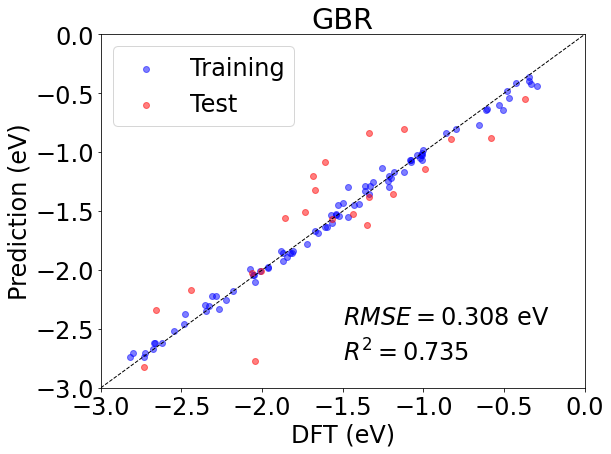

In [55]:
#  data splitting  
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size= 0.8, random_state=42) 


kfold = KFold(n_splits=5, shuffle=True, random_state=10)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)


mse_ads = [abs(s) for s in scores]
mse_tr = np.mean(mse_ads)

model.fit(X_train, y_train)
y_tr_pred = model.predict(X_train)

# print ('----------------- RMSE -----------------')
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print ('RMSE for training (v2): {:.4f} eV'.format(np.sqrt(mean_squared_error(y_tr_pred, y_train))))

R_squr_train = r2_score(y_train, y_tr_pred)
print ('R^2 for train {:.4f} eV'.format(R_squr_train))

# model testing
y_te_pred = model.predict(X_test)

MAE = mean_absolute_error(y_te_pred, y_test)
MSE = mean_squared_error(y_te_pred, y_test)
RMSE = MSE**.5
print ('calcultae average RMSE for test {:.4f} eV'.format(RMSE))
R_squr = r2_score(y_test, y_te_pred)
print ('R^2 for test {:.4f} eV'.format(R_squr))


# # Scatterplot of predicted versus actual values 
font = {'size': '24'}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8.67, 6.5))
ax.scatter(y_train, y_tr_pred, alpha=0.5, c='b', marker='o', label='Training')
ax.scatter(y_test, y_te_pred, alpha=0.5, c='r', marker='o', label='Test')

plt.xlim(-3, 0)
plt.ylim(-3, 0)

ax.set_xlabel('DFT (eV)')
ax.set_ylabel('Prediction (eV)')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, 
        scalex=False, scaley=False)

plt.text(0.5, 0.2, '$RMSE = %0.3f$ eV'% RMSE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes)
plt.text(0.5, 0.1, '$R^2 = %0.3f$'% R_squr, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes)

plt.legend(loc=0)
plt.title('GBR')
# plt.savefig('Model_performance_default_para.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Hyperparameter tuning 

In [59]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
model_grid = {'loss':['ls', 'lad', 'huber', 'quantile'],
             'n_estimators': [10,50,100],
             'learning_rate':[0.05, 0.1, 0.15],
             'max_depth':[2,3,4],
             'min_samples_split':[2,3,5],
             'min_samples_leaf':[1,2,4]}
model.get_params().keys()

model_grid_cv = RandomizedSearchCV(estimator=model,
                        param_distributions=model_grid,
                        n_iter=100,
                        cv=10,
                        verbose= True)

model_grid_cv.fit(X_train,y_train)
model_optimized = model_grid_cv.best_estimator_
print (model_optimized)

GradientBoostingRegressor(random_state=42)


dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

#  Model performance after hyperparameter tuning

MSE for training: 0.2536 eV
RMSE for training: 0.4759 eV
R^2 for train 0.9481 eV
y_te_pred: 
 [-0.63858909 -1.68763126 -2.22024415 -1.06903012 -1.05286252 -1.35098151
 -2.37081674 -0.88252723 -2.73627457 -0.48264896 -0.41417415 -0.88459691
 -1.43668048 -2.25384844 -1.52711895 -1.52771432 -2.34581596 -2.04074097
 -1.45136616 -1.55605486 -1.55358102 -1.83919579]
calcultae average MAE for test: 0.0718 eV
calcultae average MSE for test: 0.01235128 eV
calcultae average RMSE for test 0.1111 eV
R^2 for test 0.9727 eV


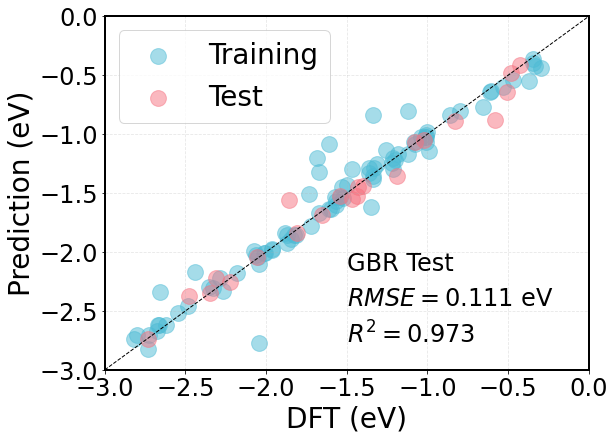

In [72]:
# 重新定义数据的分割情况, 主要是调整 random_state
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size= 0.8, random_state=47) 


kfold = KFold(n_splits=10, shuffle=False)
scores = cross_val_score(model_optimized, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)

# print ('------------------ MSE for training------------------')
mse_ads = [abs(s) for s in scores]
mse_tr = np.mean(mse_ads)

# predicted value for y_train
y_tr_pred = model.predict(X_train)
# print ('----------------- RMSE -----------------')
rmse_scores = np.sqrt(mean_squared_error(y_tr_pred, y_train))
R_squr_train = r2_score(y_train, y_tr_pred)
print ('RMSE for training (v2): {:.4f} eV'.format(rmse_scores))
print ('R^2 for train {:.4f} eV'.format(R_squr_train))

# predicted value for y_test
y_te_pred = model_optimized.predict(X_test)
MAE = mean_absolute_error(y_te_pred, y_test)
MSE = mean_squared_error(y_te_pred, y_test)
RMSE = MSE**.5
R_squr = r2_score(y_test, y_te_pred)
print ('calcultae average RMSE for test {:.4f} eV'.format(RMSE))
print ('R^2 for test {:.4f} eV'.format(R_squr))

# Scatterplot of predicted versus actual values 
font = {'size': '28'}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8.67, 6.5))
ax.scatter(y_train, y_tr_pred, alpha=0.5, c='#4DBBD5', marker='o', label='Training', s=250)
ax.scatter(y_test, y_te_pred, alpha=0.5, c='#f67280', marker='o', label='Test', s=250)

plt.xlim(-3, 0)
plt.ylim(-3, 0)

y_major_locator=MultipleLocator(0.5)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)

ax.set_xlabel('DFT (eV)')
ax.set_ylabel('Prediction (eV)')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, 
        scalex=False, scaley=False)

plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 

plt.grid(axis='x', ls='--', alpha=0.3)
plt.grid(axis='y', ls='--', alpha=0.3)

plt.text(0.5, 0.3, 'GBR Test', horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.2, '$RMSE = %0.3f$ eV'% RMSE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.1, '$R^2 = %0.3f$'% R_squr, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)

plt.legend(loc=0)
# plt.title('GBR')
# plt.savefig('Final_Model_performance_opt_para.jpg', dpi=600, bbox_inches='tight')
plt.show()

# MAE

In [73]:
# y_te_pred.to_excel('y_te_pred.xlsx')
y_te_pred
y_test
def relative_error(y_te_pred, y_test):
    relative_error = np.abs(y_te_pred - y_test)
    return relative_error
relative_error = relative_error(y_te_pred, y_test)
# relative_error

30    0.133387
5     0.037179
93    0.088146
10    0.005518
3     0.030452
0     0.162608
79    0.109985
44    0.304195
22    0.005380
54    0.002376
18    0.012279
37    0.054204
61    0.039576
68    0.030447
62    0.091036
74    0.014837
14    0.004712
94    0.016332
97    0.019136
1     0.298988
40    0.087294
75    0.030988
Name: $\mathregular{E_{ad}(CO)}$, dtype: float64

In [74]:
MAE = mean_absolute_error(y_te_pred, y_test)
# MAE

0.07177524909677944

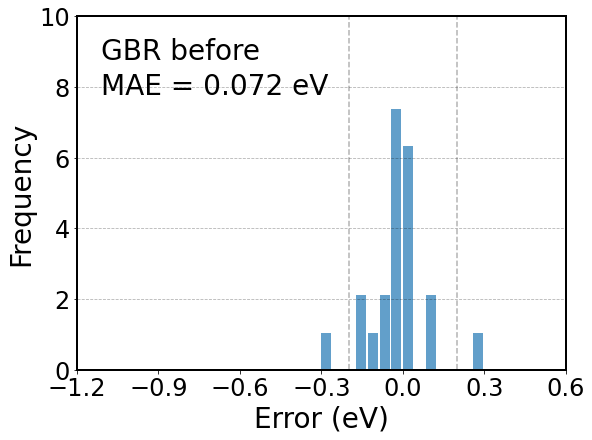

In [76]:
error1 = y_te_pred - y_test
error1
def relative_error(y_te_pred, y_test):
    relative_error = np.abs(y_te_pred - y_test)
    return relative_error
relative_error = relative_error(y_te_pred, y_test)
relative_error

MAE = mean_absolute_error(y_te_pred, y_test)
MAE



# Histogram for MAE
font={'weight':'normal', 'size': 28}

fig, ax = plt.subplots(figsize=(8.76, 6.5))

n, bins, patches = plt.hist(x=error1, bins='auto', alpha=0.7, rwidth=0.85, density=True)

plt.xlabel('Error (eV)', fontsize=28)
plt.ylabel('Frequency', fontsize=28)

plt.xlim(-1.2, 0.6)
plt.ylim(0, 10)
ax.xaxis.set_major_locator(MultipleLocator(0.3))

plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

plt.grid(axis='y',ls='--',  c='black', alpha=0.3)

plt.text(0.05, 0.9, 'GBR before', horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=28)
plt.text(0.05, 0.8, 'MAE = %0.3f eV'% MAE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes,  fontsize=28)


ax.plot([-0.2, -0.2], [-100, 100], linestyle='--', c='black', alpha=0.3)
ax.plot([0.2, 0.2], [-100, 100], linestyle='--', c='black', alpha=0.3)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 

# # plt.title('XGBR_opt without zero importance features \n')
# plt.savefig('MAE error frequency.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Visualization of decision trees

In [78]:
import graphviz
from sklearn.datasets import make_regression
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import plot_tree
from sklearn import tree

headers = features.columns.values.tolist()
# headers

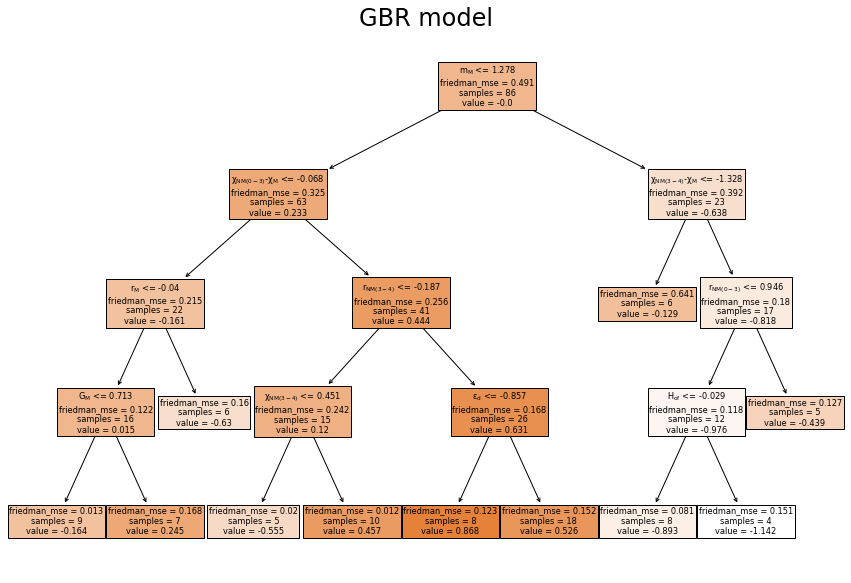

In [79]:
# assume X_train and y_train are your training data
model_optimized

font = {'size':20}
plt.rc("font", **font)

first_tree = model_optimized.estimators_[0][0]

# plot the decision tree
plt.figure(figsize=(15,10))
tree.plot_tree(first_tree, feature_names=X_train.columns, filled=bool, class_names=["blue", "green"], )

plt.title('GBR model')
# plt.savefig('tree_0.jpg', dpi=600, bbox_inches='tight')
plt.show()

# 决策树的 可视化 end

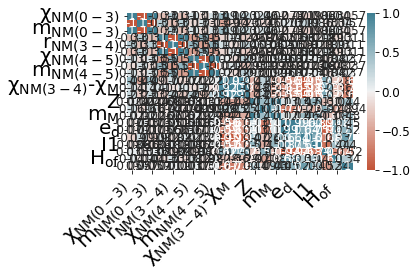

In [86]:
font = {'size':12}
plt.rc('font', **font)

coeff = features
corr = coeff.corr()
ax = sns.heatmap(corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=220),annot=True)

ax.set_xticklabels(ax.get_xticklabels(),horizontalalignment='right',rotation=45,size=20)
ax.set_yticklabels(ax.get_xticklabels(),horizontalalignment='right',size=20)
# ax.set_xlabel('DFT (eV)')

plt.rcParams['figure.figsize'] = (20, 20)
plt.tight_layout()

# fig = ax.get_figure()
# fig.savefig('Pearson.jpeg', dpi=600,)

# Histogram of feature importance

In [87]:
headers = features.columns.values.tolist()
headers[0]
len(headers)
# headers
# headers

['$\\mathregular{χ_{NM(0-3)}}$',
 '$\\mathregular{r_{NM(0-3)}}$',
 '$\\mathregular{m_{NM(0-3)}}$',
 '$\\mathregular{χ_{NM(3-4)}}$',
 '$\\mathregular{r_{NM(3-4)}}$',
 '$\\mathregular{m_{NM(3-4)}}$',
 '$\\mathregular{χ_{NM(4-5)}}$',
 '$\\mathregular{r_{NM(4-5)}}$',
 '$\\mathregular{m_{NM(4-5)}}$',
 '$\\mathregular{χ_{NM(0-3)}}$-$\\mathregular{χ_{M}}$',
 '$\\mathregular{χ_{NM(3-4)}}$-$\\mathregular{χ_{M}}$',
 '$\\mathregular{χ_{NM(4-5)}}$-$\\mathregular{χ_{M}}$',
 'Z',
 '$\\mathregular{r_{M}}$',
 '$\\mathregular{m_{M}}$',
 '$\\mathregular{G_{M}}$',
 '$\\mathregular{e_{d}}$',
 '$\\mathregular{χ_{M}}$',
 'I1',
 '$\\mathregular{ε_{d}}$',
 '$\\mathregular{H_{of}}$',
 '$\\mathregular{EA_{M}}$']

In [89]:
# color list
colors = [ 
'#99CCFF',  '#99FF99', 
'#CCCC00', '#CC99FF', '#8FCD13', '#FF99CC', '#4F9186',
'#c86b85', '#878ecd', '#a8e6cf',  '#3f72af', '#f08a5d', 
'#ffde7d',  '#f67280', '#307672', '#fbac91', '#d4a5a5',
'#769fcd',  '#30e3ca', '#FCBAD3', '#aa96da', '#4DBBD5', ]


22
[0.00272244 0.00514643 0.00530454 0.00776866 0.00878418 0.01197698
 0.0151329  0.01597994 0.01772392 0.02025257 0.0236872  0.02988229
 0.033492   0.034524   0.04149871 0.04233476 0.05413554 0.05528019
 0.11872167 0.11989594 0.14937294 0.18638219]
['I1' '$\\mathregular{e_{d}}$' '$\\mathregular{r_{NM(0-3)}}$'
 '$\\mathregular{G_{M}}$' '$\\mathregular{χ_{M}}$'
 '$\\mathregular{m_{NM(0-3)}}$' '$\\mathregular{m_{NM(4-5)}}$'
 '$\\mathregular{χ_{NM(0-3)}}$' '$\\mathregular{r_{NM(3-4)}}$'
 '$\\mathregular{ε_{d}}$' '$\\mathregular{m_{NM(3-4)}}$'
 '$\\mathregular{χ_{NM(4-5)}}$' '$\\mathregular{H_{of}}$'
 '$\\mathregular{χ_{NM(3-4)}}$' '$\\mathregular{EA_{M}}$'
 '$\\mathregular{r_{NM(4-5)}}$'
 '$\\mathregular{χ_{NM(3-4)}}$-$\\mathregular{χ_{M}}$'
 '$\\mathregular{χ_{NM(4-5)}}$-$\\mathregular{χ_{M}}$'
 '$\\mathregular{m_{M}}$' 'Z' '$\\mathregular{r_{M}}$'
 '$\\mathregular{χ_{NM(0-3)}}$-$\\mathregular{χ_{M}}$']


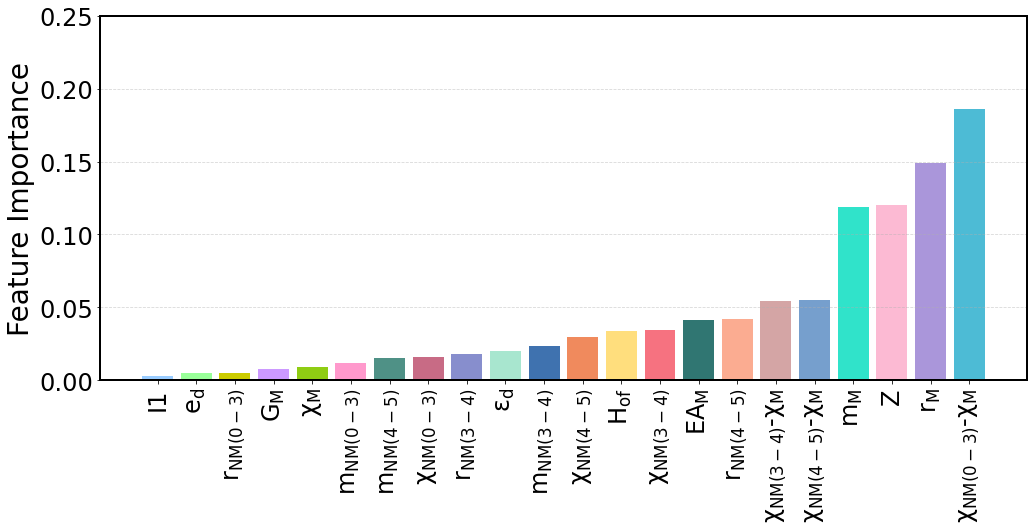

In [90]:
# importances = model_optimized.feature_importances_
importances = model.feature_importances_
headers = headers 
print (len(headers))

sorted_idx = np.argsort(importances)
sorted_idx

importances_2 = importances[sorted_idx]
print (importances_2)

headers_2 = np.array(headers)[sorted_idx]
# headers = headers[len(headers)]
print (headers_2)

font = {'size': '28'}
plt.rc('font', **font)

fig, ax = plt.subplots( figsize=(15, 8))
plt.bar(headers_2, importances_2, color=colors)

# ax.set_xlabel("Feature Importance", fontsize = 28)
ax.set_ylabel("Feature Importance", fontsize = 28)
ax.tick_params(axis='y', )
ax.tick_params(axis='x', rotation = 90)

plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);####设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);  ####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2); ####设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2); 

# plt.title('GBR feature importance')
plt.grid(axis='y', ls='--', alpha=0.5)

ax.set_ylim(0, 0.25)

plt.tight_layout()
# fig.savefig('Final_Feature importance_all-heng.jpeg', dpi=600,)

# Pie chart of feature importance

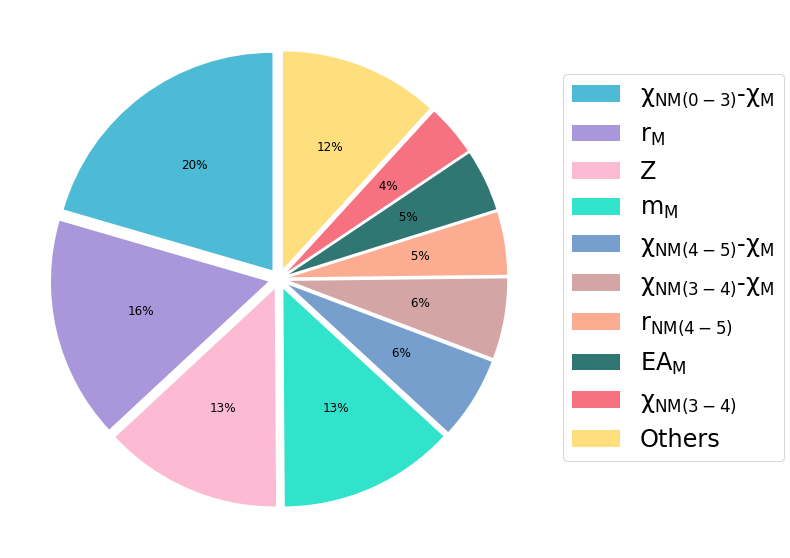

In [91]:
# 特征重要性饼状图
model_optimized = model

# 默认是从小到大的排序
sorted_idx = np.argsort(importances)
sorted_idx

# sort 排序得到的 index， 而不是具体的数
importances_2 = importances[sorted_idx]
importances_2

# pie
feature_numbers = 13
idx_third_tem = model_optimized.feature_importances_.argsort()   # 对特征重要性排序  
idx_third = idx_third_tem[-feature_numbers]          # 测试一下， 最后一个是多少

# 得到从大到小的index
feature_idx = (-model_optimized.feature_importances_).argsort()[:feature_numbers] 

feature_idx

# 对importance 加负号，然后排序，得到的index就是 从大到小的
(-model_optimized.feature_importances_) 

(-model_optimized.feature_importances_).argsort()

# 得到特征的名字
name_features = np.array(headers)[feature_idx]  
name_features

(-model_optimized.feature_importances_).argsort()[:feature_numbers] 

# 特征重要性的具体的数据
selected_features = model_optimized.feature_importances_[feature_idx]
selected_features



# 只画前 n 个重要的特征，而将其他的合并为others
font={'weight':'normal', 
      'size': 12}

cmap = plt.get_cmap("tab20")

colors = cmap(np.arange(len(headers)))

labels= name_features  ## np.array(headers)[tree_importance_sorted_idx[3:]]
sizes= selected_features

#  不同块之间的分割
myexplode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
             0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
             0.05, 0.05,]

fig, ax = plt.subplots(figsize=(15, 10))

top_sizes = sizes[:9]
top_labels = labels[:9]

other_label = 'Others'
other_size = sum(sizes[9:])


labels_to_plot = np.append(top_labels, [other_label])
labels_to_plot

sizes_to_plot = np.append(top_sizes, [other_size])
sizes_to_plot

wedges,texts, autotexts = plt.pie(sizes_to_plot, 
#                                    colors=colors[:11], 
                                  colors=['#4DBBD5', '#aa96da','#FCBAD3','#30e3ca','#769fcd', 
                                           '#d4a5a5','#fbac91','#307672',  '#f67280',  '#ffde7d', ],
                                   explode = myexplode[:10], 
                                   startangle=90, 
                                   textprops=font,
                                  autopct='%2.f%%',)

ax.legend(labels_to_plot, bbox_to_anchor=(1, 0, 0, 0.9), fontsize=24, ncol=1)

# plt.title('GBR feature importance', fontsize=28)
# fig.savefig('Feature importance.jpg', dpi=600, bbox_inches='tight')
plt.show()

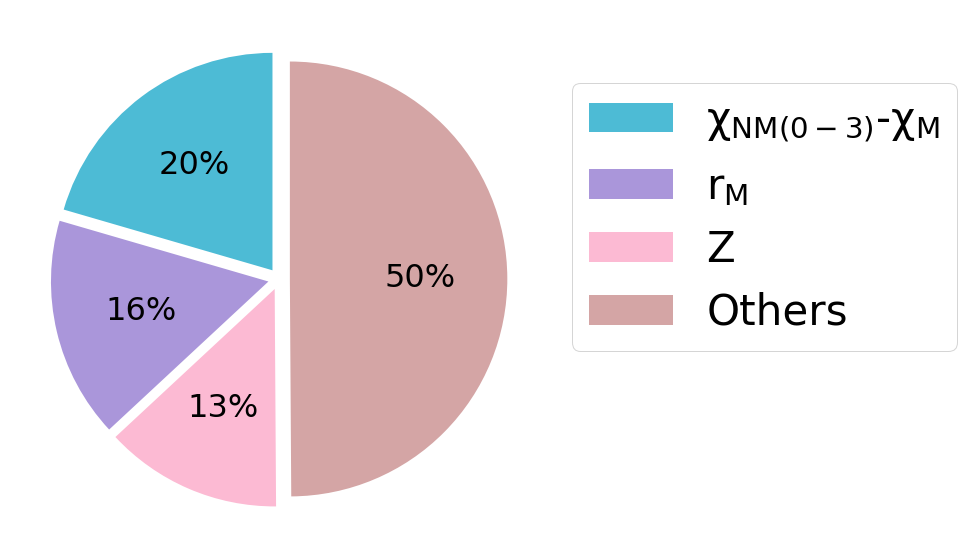

In [93]:
# 只画 n 十个重要的特征，而将其他的合并为others
font={'weight':'normal', 
      'size': 32}

cmap = plt.get_cmap("tab20")

colors = cmap(np.arange(len(headers)))

labels= name_features  ## np.array(headers)[tree_importance_sorted_idx[3:]]
sizes= selected_features

#  不同块之间的分割
myexplode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
             0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
             0.05, 0.05,]
fig, ax = plt.subplots(figsize=(15, 10))

top_sizes = sizes[:3]
top_labels = labels[:3]


other_label = 'Others'
other_size = sum(sizes[3:])

labels_to_plot = np.append(top_labels, [other_label])
# labels_to_plot
sizes_to_plot = np.append(top_sizes, [other_size])
# sizes_to_plot

wedges,texts, autotexts = plt.pie(sizes_to_plot, 
#                                    colors=colors[:11], 
                                  colors=['#4DBBD5', '#aa96da','#FCBAD3', '#d4a5a5',],
                                   explode = myexplode[:4], 
                                   startangle=90, 
                                   textprops=font,
                                  autopct='%2.f%%',)

ax.legend(labels_to_plot, bbox_to_anchor=(1, 0, 0, 0.9), fontsize=42, ncol=1)

# plt.title('GBR feature importance', fontsize=28)
# fig.savefig('Feature importance_top_3.jpg', dpi=600, bbox_inches='tight')
plt.show()

# 500 times training/test

In [ ]:
# # 确定 R_squr for trainging 
print ('---500 times running ---')
R2_2nd = []
RMSE_2nd = []

R2_2nd_test = []
RMSE_2nd_test = []

for i in range(0,500):
    print (i)
    X_train, X_test, y_train, y_test = train_test_split(features, target, train_size= 0.8) 

    y_tr_pred = model_optimized.predict(X_train)
    rmse_scores = np.sqrt(mean_squared_error(y_tr_pred, y_train))
    RMSE_2nd.append(rmse_scores)
    print ('RMSE for training (v2): {:.4f} eV'.format(np.sqrt(mean_squared_error(y_tr_pred, y_train))))
    
    R_squr_train = r2_score(y_train, y_tr_pred)
    print ('R^2 for train {:.4f} eV'.format(R_squr_train))


    y_tr_pred = model_optimized.predict(X_train)
    R_squr_train = r2_score(y_train, y_tr_pred)
    print ('R^2 for train {:.4f} '.format(R_squr_train))
    R2_2nd.append(R_squr_train)
    
    # 开始做测试
    y_te_pred = model_optimized.predict(X_test)
    MSE = mean_squared_error(y_te_pred, y_test)
    RMSE = MSE**.5
    
    RMSE_2nd_test.append(RMSE)
    
    R_squr = r2_score(y_test, y_te_pred)
    R2_2nd_test.append(R_squr)

test1 = pd.DataFrame({'gbr-rmse':RMSE_2nd})
test2 = pd.DataFrame({'gbr-r2':R2_2nd})
test3 = pd.DataFrame({'gbr-rmse_test':RMSE_2nd_test})
test4 = pd.DataFrame({'gbr-r2_test':R2_2nd_test})

In [ ]:
# Creating Excel Writer Object from Pandas  
writer = pd.ExcelWriter('model_performance.xlsx', mode='a', engine='openpyxl')
workbook=writer.book
test1.to_excel(writer,sheet_name='gbr1',startrow=0 , startcol=0)   
test2.to_excel(writer,sheet_name='gbr2',startrow=0, startcol=0)
test3.to_excel(writer,sheet_name='gbr3',startrow=0, startcol=0)
test4.to_excel(writer,sheet_name='gbr4',startrow=0, startcol=0)
writer.close()   